In [3]:
#!/usr/bin/env python3
"""
Title: Sine Wave Prediction using a Vanilla RNN in PyTorch
Description:
    This script demonstrates how to build and train a Vanilla Recurrent Neural Network (RNN)
    to perform time series forecasting on a sine wave dataset. The task is to predict the next
    value in a sequence of sine wave values given a fixed-length history. The script is organized
    into several distinct sections, each explaining a part of the process in an elementary way.

    The key steps include:
      1. Environment Setup and Importing Libraries
      2. Data Generation: Creating a Sine Wave Dataset
      3. Data Preprocessing: Converting the continuous series into sequences and targets
      4. Splitting the Data into Training and Testing Sets
      5. Defining a Vanilla RNN Model in PyTorch for Regression
      6. Training the RNN Model with Detailed Logging and Loss Plotting
      7. Evaluating the Model on Test Data with Visualization
      8. Saving and Loading the Trained Model
      9. Additional Experiments: Varying Sequence Lengths and Hyperparameter Sensitivity
     10. Hyperparameter Sensitivity Analysis: Grid Search over Hidden Size and Learning Rate
     11. Summary of Experiments and Final Thoughts

"""

'\nTitle: Sine Wave Prediction using a Vanilla RNN in PyTorch\nDescription:\n    This script demonstrates how to build and train a Vanilla Recurrent Neural Network (RNN)\n    to perform time series forecasting on a sine wave dataset. The task is to predict the next\n    value in a sequence of sine wave values given a fixed-length history. The script is organized\n    into several distinct sections, each explaining a part of the process in an elementary way.\n    \n    The key steps include:\n      1. Environment Setup and Importing Libraries\n      2. Data Generation: Creating a Sine Wave Dataset\n      3. Data Preprocessing: Converting the continuous series into sequences and targets\n      4. Splitting the Data into Training and Testing Sets\n      5. Defining a Vanilla RNN Model in PyTorch for Regression\n      6. Training the RNN Model with Detailed Logging and Loss Plotting\n      7. Evaluating the Model on Test Data with Visualization\n      8. Saving and Loading the Trained Mode

In [4]:
# =============================================================================
# Section 1: Environment Setup and Importing Libraries
# =============================================================================
# In this section, we import all necessary libraries, set random seeds for reproducibility,
# and configure the computation device (GPU if available, otherwise CPU).
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Set random seeds to ensure reproducible results
torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

# Configure the device: use GPU if available for acceleration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("==== Environment Setup ====")
print("PyTorch Version:", torch.__version__)
print("CUDA Available:", torch.cuda.is_available())
print("Using Device:", device)
print("=" * 80)


==== Environment Setup ====
PyTorch Version: 2.5.1+cu124
CUDA Available: False
Using Device: cpu


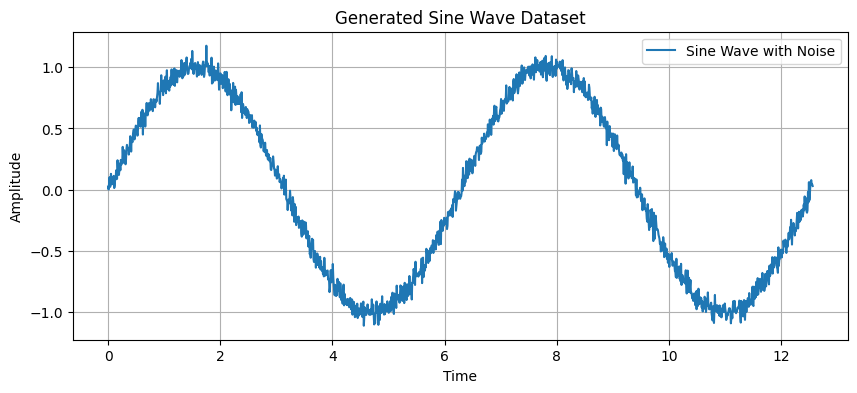

Data Generation Completed:
Total data points generated: 1500


In [5]:
# =============================================================================
# Section 2: Data Generation - Creating a Sine Wave Dataset
# =============================================================================
# In time series forecasting, a sine wave is a common synthetic dataset because it is periodic.
# Here, we generate a sine wave with added Gaussian noise. The function below creates the dataset.
def generate_sine_wave_data(num_points=1000, noise_std=0.1):
    """
    Generates a sine wave dataset with optional Gaussian noise.

    Args:
        num_points (int): Number of data points.
        noise_std (float): Standard deviation for the added Gaussian noise.

    Returns:
        x_values (np.array): The time steps.
        y_values (np.array): The noisy sine wave values.
    """
    x_values = np.linspace(0, 4 * np.pi, num_points)
    y_values = np.sin(x_values)
    if noise_std > 0:
        noise = np.random.normal(0, noise_std, size=num_points)
        y_values += noise
    return x_values, y_values

# Generate sine wave data with a specified number of points and noise level.
num_data_points = 1500  # Total data points in our dataset
x_vals, y_vals = generate_sine_wave_data(num_points=num_data_points, noise_std=0.05)

# Plot the generated sine wave
plt.figure(figsize=(10, 4))
plt.plot(x_vals, y_vals, label="Sine Wave with Noise")
plt.title("Generated Sine Wave Dataset")
plt.xlabel("Time")
plt.ylabel("Amplitude")
plt.legend()
plt.grid(True)
plt.show()

print("Data Generation Completed:")
print("Total data points generated:", num_data_points)
print("=" * 80)

In [6]:
# =============================================================================
# Section 3: Data Preprocessing - Creating Sequences and Targets
# =============================================================================
# For an RNN, we must transform the continuous time series into sequences.
# Each input sequence (of fixed length) is used to predict the subsequent value.
def create_sequences(data, seq_length):
    """
    Converts a time series into overlapping sequences and their corresponding targets.

    Args:
        data (np.array): The time series data.
        seq_length (int): The length of each sequence.

    Returns:
        sequences (np.array): Array of sequences (shape: [num_samples, seq_length]).
        targets (np.array): Array of targets (shape: [num_samples]).
    """
    sequences = []
    targets = []
    for i in range(len(data) - seq_length):
        seq = data[i:i + seq_length]
        target = data[i + seq_length]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

# Define the sequence length (number of past time steps used to predict the next value)
sequence_length = 50

# Create input sequences and targets from the sine wave data
sequences, targets = create_sequences(y_vals, sequence_length)
print("Sequences shape:", sequences.shape)
print("Targets shape:", targets.shape)

# Although the sine wave is already bounded between -1 and 1, we apply normalization for consistency.
mean_val = np.mean(sequences)
std_val = np.std(sequences)
sequences_normalized = (sequences - mean_val) / std_val
targets_normalized = (targets - mean_val) / std_val

# Convert the numpy arrays to PyTorch tensors.
# The input tensor is reshaped to (num_samples, sequence_length, 1) because we have one feature.
sequences_tensor = torch.tensor(sequences_normalized, dtype=torch.float32).unsqueeze(-1).to(device)
targets_tensor = torch.tensor(targets_normalized, dtype=torch.float32).unsqueeze(-1).to(device)

print("Normalized sequences tensor shape:", sequences_tensor.shape)
print("Normalized targets tensor shape:", targets_tensor.shape)
print("=" * 80)

Sequences shape: (1450, 50)
Targets shape: (1450,)
Normalized sequences tensor shape: torch.Size([1450, 50, 1])
Normalized targets tensor shape: torch.Size([1450, 1])


In [7]:
# =============================================================================
# Section 4: Splitting the Data into Training and Testing Sets
# =============================================================================
# We split the data into training and testing sets. An 80/20 split is common.
split_ratio = 0.8
num_train = int(len(sequences_tensor) * split_ratio)
num_test = len(sequences_tensor) - num_train

train_X = sequences_tensor[:num_train]
train_y = targets_tensor[:num_train]
test_X = sequences_tensor[num_train:]
test_y = targets_tensor[num_train:]

print("Training set shape:", train_X.shape, train_y.shape)
print("Testing set shape:", test_X.shape, test_y.shape)
print("=" * 80)

# Create DataLoaders to iterate over the dataset in batches during training and testing.
batch_size = 32
train_dataset = torch.utils.data.TensorDataset(train_X, train_y)
test_dataset = torch.utils.data.TensorDataset(test_X, test_y)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

Training set shape: torch.Size([1160, 50, 1]) torch.Size([1160, 1])
Testing set shape: torch.Size([290, 50, 1]) torch.Size([290, 1])


In [8]:
# =============================================================================
# Section 5: Defining the Vanilla RNN Model for Regression
# =============================================================================
# We now define a simple Vanilla RNN model using PyTorch.
# This model comprises an RNN layer and a fully connected (FC) layer that maps the last time step's
# hidden state to the output prediction.
class SineRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        """
        Initializes the Vanilla RNN model.

        Args:
            input_size (int): Number of features per time step.
            hidden_size (int): Number of hidden units in the RNN.
            num_layers (int): Number of stacked RNN layers.
            output_size (int): Number of outputs (for regression, typically 1).
        """
        super(SineRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        # The RNN layer uses a tanh activation by default.
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # The fully connected layer produces the final output.
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        """
        Defines the forward pass of the RNN model.

        Args:
            x (Tensor): Input tensor of shape (batch_size, sequence_length, input_size).

        Returns:
            Tensor: Output predictions of shape (batch_size, output_size).
        """
        # Initialize the hidden state to zeros.
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        # Pass the input through the RNN layer.
        out, _ = self.rnn(x, h0)
        # Use the output of the last time step for the final prediction.
        out = self.fc(out[:, -1, :])
        return out

# Set model parameters
input_dim = 1      # One feature per time step (sine value)
hidden_dim = 50    # Number of hidden units (tunable)
num_layers = 2     # Number of RNN layers
output_dim = 1     # Single output (regression)

# Instantiate the model and print its architecture.
model = SineRNN(input_dim, hidden_dim, num_layers, output_dim).to(device)
print("==== SineRNN Model Architecture ====")
print(model)
print("=" * 80)

==== SineRNN Model Architecture ====
SineRNN(
  (rnn): RNN(1, 50, num_layers=2, batch_first=True)
  (fc): Linear(in_features=50, out_features=1, bias=True)
)


==== Starting Training of SineRNN Model ====
[SineRNN] Epoch 5/50, Loss: 0.006964
[SineRNN] Epoch 10/50, Loss: 0.007314
[SineRNN] Epoch 15/50, Loss: 0.007125
[SineRNN] Epoch 20/50, Loss: 0.007301
[SineRNN] Epoch 25/50, Loss: 0.006939
[SineRNN] Epoch 30/50, Loss: 0.006296
[SineRNN] Epoch 35/50, Loss: 0.006738
[SineRNN] Epoch 40/50, Loss: 0.006438
[SineRNN] Epoch 45/50, Loss: 0.006112
[SineRNN] Epoch 50/50, Loss: 0.006787
Training completed in 37.52 seconds.


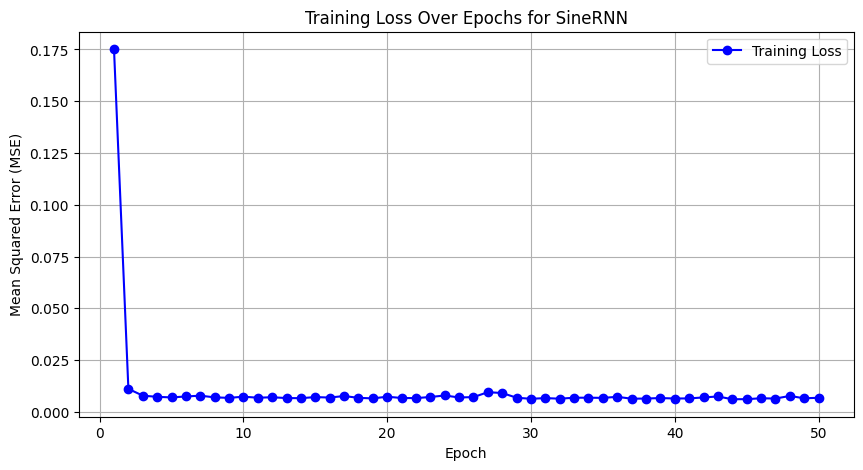

In [9]:
# =============================================================================
# Section 6: Training the RNN Model
# =============================================================================
# We now train the RNN model using Mean Squared Error (MSE) as the loss function and the Adam optimizer.
# The training loop iterates over the training data, computes the loss, backpropagates the errors,
# and updates the model parameters.
num_epochs = 50
learning_rate = 0.001

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

train_loss_history = []  # List to record training loss for each epoch

print("==== Starting Training of SineRNN Model ====")
start_time = time.time()
for epoch in range(num_epochs):
    epoch_loss = 0.0
    model.train()  # Set the model to training mode.
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()          # Reset gradients.
        outputs = model(batch_X)         # Forward pass: get predictions.
        loss = criterion(outputs, batch_y)  # Compute the MSE loss.
        loss.backward()                # Backpropagate the loss.
        optimizer.step()               # Update the model parameters.
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    train_loss_history.append(avg_epoch_loss)
    if (epoch + 1) % 5 == 0:
        print(f"[SineRNN] Epoch {epoch+1}/{num_epochs}, Loss: {avg_epoch_loss:.6f}")

print("Training completed in {:.2f} seconds.".format(time.time() - start_time))
print("=" * 80)

# Plot the training loss over epochs.
plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_loss_history, marker='o', color='blue', label='Training Loss')
plt.title("Training Loss Over Epochs for SineRNN")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error (MSE)")
plt.legend()
plt.grid(True)
plt.show()

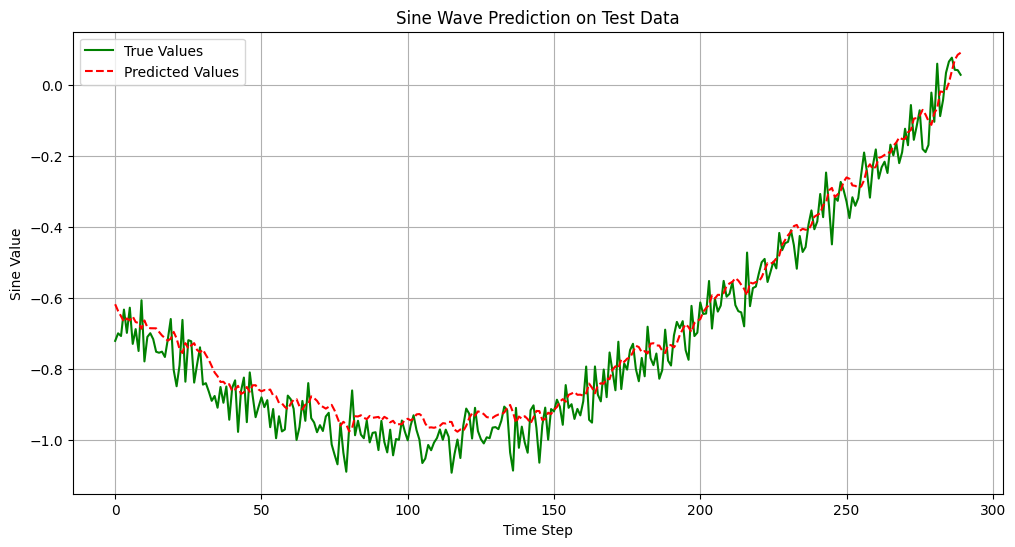

In [10]:
# =============================================================================
# Section 7: Evaluating the Model on Test Data
# =============================================================================
# After training, we evaluate our model on the test dataset.
# We perform predictions on the test sequences and compare the outputs with the true values.
# The predictions are then denormalized to recover the original scale.
model.eval()  # Set the model to evaluation mode.

predictions = []
true_values = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X)
        predictions.append(outputs.cpu().numpy())
        true_values.append(batch_y.cpu().numpy())

# Concatenate the outputs from all batches.
predictions = np.concatenate(predictions).flatten()
true_values = np.concatenate(true_values).flatten()

# Denormalize the predictions and true values to obtain values on the original scale.
predictions_denorm = predictions * std_val + mean_val
true_values_denorm = true_values * std_val + mean_val

# Plot the predicted vs. true sine values on the test set.
plt.figure(figsize=(12, 6))
plt.plot(true_values_denorm, label="True Values", color="green")
plt.plot(predictions_denorm, label="Predicted Values", color="red", linestyle="--")
plt.title("Sine Wave Prediction on Test Data")
plt.xlabel("Time Step")
plt.ylabel("Sine Value")
plt.legend()
plt.grid(True)
plt.show()

==== Evaluation Metrics on Test Data ====
Mean Absolute Error (MAE): 0.0526
Root Mean Squared Error (RMSE): 0.0630


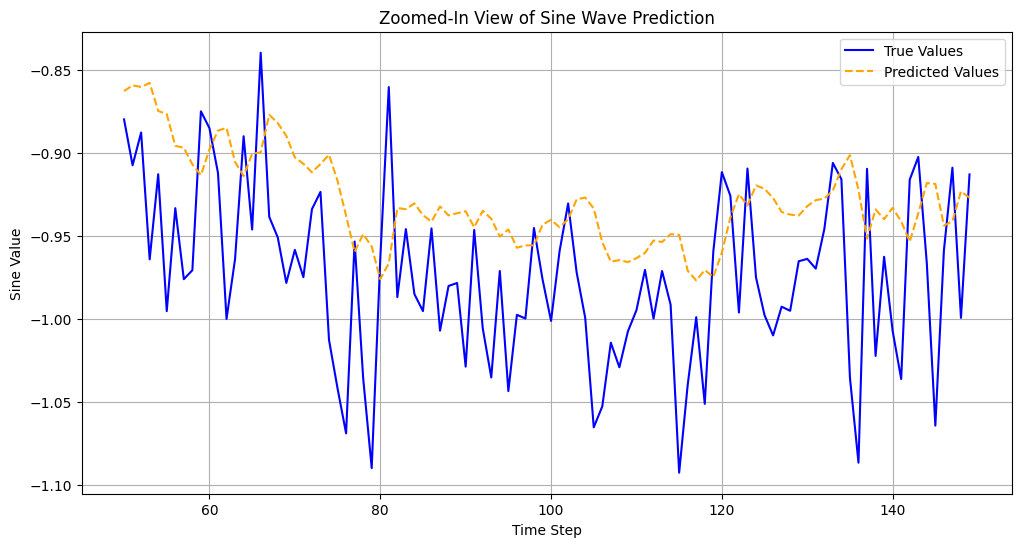

In [11]:
# =============================================================================
# Section 8: Detailed Analysis and Visualization of Model Performance
# =============================================================================
# In this section, we provide further analysis of our model’s performance.
# We compute evaluation metrics and produce additional plots for a closer inspection.
mae = mean_absolute_error(true_values_denorm, predictions_denorm)
rmse = np.sqrt(mean_squared_error(true_values_denorm, predictions_denorm))

print("==== Evaluation Metrics on Test Data ====")
print("Mean Absolute Error (MAE): {:.4f}".format(mae))
print("Root Mean Squared Error (RMSE): {:.4f}".format(rmse))
print("=" * 80)

# Plot a zoomed-in view of a segment of the test predictions to better visualize performance.
zoom_start = 50
zoom_end = 150
plt.figure(figsize=(12, 6))
plt.plot(range(zoom_start, zoom_end), true_values_denorm[zoom_start:zoom_end], label="True Values", color="blue")
plt.plot(range(zoom_start, zoom_end), predictions_denorm[zoom_start:zoom_end], label="Predicted Values", color="orange", linestyle="--")
plt.title("Zoomed-In View of Sine Wave Prediction")
plt.xlabel("Time Step")
plt.ylabel("Sine Value")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# =============================================================================
# Section 9: Saving and Loading the Trained Model
# =============================================================================
# To avoid retraining the model every time, we can save the trained model to disk.
# Later, we can load the model and use it for further predictions without additional training.
model_save_path = "sine_rnn_model.pth"
torch.save(model.state_dict(), model_save_path)
print("Model saved to", model_save_path)

# Demonstrate how to load the saved model.
loaded_model = SineRNN(input_dim, hidden_dim, num_layers, output_dim).to(device)
loaded_model.load_state_dict(torch.load(model_save_path))
loaded_model.eval()
print("Model loaded from", model_save_path)
print("=" * 80)

Model saved to sine_rnn_model.pth
Model loaded from sine_rnn_model.pth


<ipython-input-12-29d0f00ebd68>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded_model.load_state_dict(torch.load(model_save_path))


==== Additional Experiments: Varying Sequence Lengths ====

Training with sequence length: 30
Seq Length 30: Epoch 5/30, Loss: 0.007473
Seq Length 30: Epoch 10/30, Loss: 0.007323
Seq Length 30: Epoch 15/30, Loss: 0.006539
Seq Length 30: Epoch 20/30, Loss: 0.006568
Seq Length 30: Epoch 25/30, Loss: 0.006710
Seq Length 30: Epoch 30/30, Loss: 0.007773

Training with sequence length: 50
Seq Length 50: Epoch 5/30, Loss: 0.007126
Seq Length 50: Epoch 10/30, Loss: 0.006469
Seq Length 50: Epoch 15/30, Loss: 0.006463
Seq Length 50: Epoch 20/30, Loss: 0.006747
Seq Length 50: Epoch 25/30, Loss: 0.007110
Seq Length 50: Epoch 30/30, Loss: 0.007676

Training with sequence length: 70
Seq Length 70: Epoch 5/30, Loss: 0.007177
Seq Length 70: Epoch 10/30, Loss: 0.007678
Seq Length 70: Epoch 15/30, Loss: 0.006659
Seq Length 70: Epoch 20/30, Loss: 0.006548
Seq Length 70: Epoch 25/30, Loss: 0.006949
Seq Length 70: Epoch 30/30, Loss: 0.006635


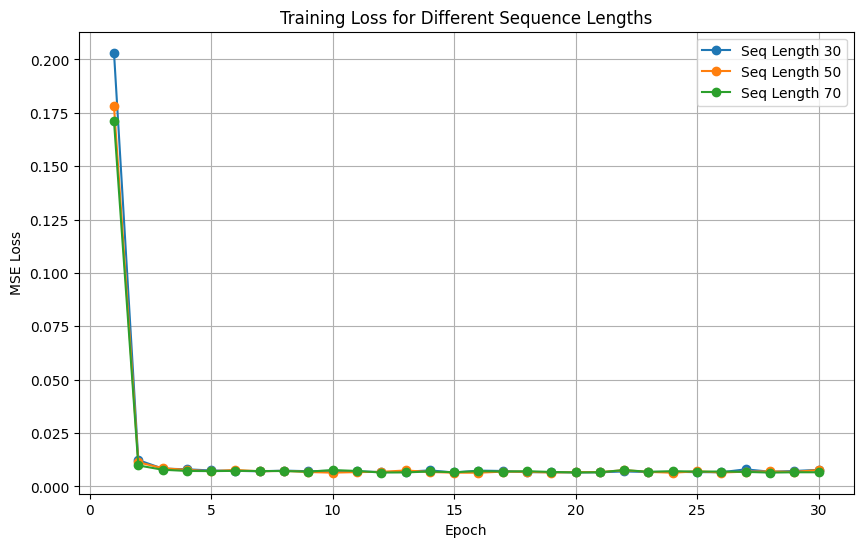

In [13]:
# =============================================================================
# Section 10: Additional Experiments - Varying Sequence Lengths
# =============================================================================
# We now conduct experiments to observe how changing the sequence length affects training.
# The function below trains a model with a given sequence length and returns the training loss history.
def train_model_with_seq_length(seq_len, num_epochs=30):
    """
    Trains the SineRNN model with a specified sequence length and returns the training loss history.

    Args:
        seq_len (int): The sequence length for training.
        num_epochs (int): The number of epochs to train.

    Returns:
        list: The training loss history over epochs.
    """
    # Create new sequences using the specified sequence length.
    seq_data, target_data = create_sequences(y_vals, seq_len)
    mean_temp = np.mean(seq_data)
    std_temp = np.std(seq_data)
    seq_data_norm = (seq_data - mean_temp) / std_temp
    target_data_norm = (target_data - mean_temp) / std_temp
    seq_tensor_local = torch.tensor(seq_data_norm, dtype=torch.float32).unsqueeze(-1).to(device)
    target_tensor_local = torch.tensor(target_data_norm, dtype=torch.float32).unsqueeze(-1).to(device)

    # Split the data (using the same split ratio as before).
    num_train_local = int(len(seq_tensor_local) * split_ratio)
    train_X_local = seq_tensor_local[:num_train_local]
    train_y_local = target_tensor_local[:num_train_local]
    local_dataset = torch.utils.data.TensorDataset(train_X_local, train_y_local)
    local_loader = torch.utils.data.DataLoader(local_dataset, batch_size=batch_size, shuffle=True)

    # Instantiate a new model for this experiment.
    model_local = SineRNN(input_dim, hidden_dim, num_layers, output_dim).to(device)
    optimizer_local = optim.Adam(model_local.parameters(), lr=learning_rate)
    criterion_local = nn.MSELoss()
    loss_history_local = []

    for epoch in range(num_epochs):
        epoch_loss_local = 0.0
        model_local.train()
        for batch_X_local, batch_y_local in local_loader:
            optimizer_local.zero_grad()
            outputs_local = model_local(batch_X_local)
            loss_local = criterion_local(outputs_local, batch_y_local)
            loss_local.backward()
            optimizer_local.step()
            epoch_loss_local += loss_local.item()
        avg_loss_local = epoch_loss_local / len(local_loader)
        loss_history_local.append(avg_loss_local)
        if (epoch + 1) % 5 == 0:
            print(f"Seq Length {seq_len}: Epoch {epoch+1}/{num_epochs}, Loss: {avg_loss_local:.6f}")
    return loss_history_local

# Experiment with different sequence lengths: 30, 50, and 70.
print("==== Additional Experiments: Varying Sequence Lengths ====")
seq_lengths = [30, 50, 70]
loss_histories = {}

for seq_len in seq_lengths:
    print("\nTraining with sequence length:", seq_len)
    loss_histories[seq_len] = train_model_with_seq_length(seq_len, num_epochs=30)

# Plot the training loss curves for each sequence length.
plt.figure(figsize=(10, 6))
for seq_len in seq_lengths:
    plt.plot(range(1, 31), loss_histories[seq_len], marker='o', label=f"Seq Length {seq_len}")
plt.title("Training Loss for Different Sequence Lengths")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.grid(True)
plt.show()

In [14]:
# =============================================================================
# Section 11: Hyperparameter Sensitivity Analysis
# =============================================================================
# Here we perform a grid search over different hidden sizes and learning rates to see how they impact the model's performance.
def hyperparameter_experiment(hidden_sizes, learning_rates, num_epochs_ex=20):
    """
    Performs a grid search over given hidden sizes and learning rates.

    Args:
        hidden_sizes (list): List of hidden sizes to test.
        learning_rates (list): List of learning rates to test.
        num_epochs_ex (int): Number of epochs for each experiment.

    Returns:
        dict: A dictionary mapping (hidden_size, learning_rate) to the final training loss.
    """
    results = {}
    for h in hidden_sizes:
        for lr in learning_rates:
            print(f"\nTraining with hidden_size={h}, learning_rate={lr}")
            # Instantiate a new model with the current hidden size.
            model_ex = SineRNN(input_dim, h, num_layers, output_dim).to(device)
            optimizer_ex = optim.Adam(model_ex.parameters(), lr=lr)
            loss_history_ex = []
            for epoch in range(num_epochs_ex):
                epoch_loss_ex = 0.0
                model_ex.train()
                for batch_X_ex, batch_y_ex in train_loader:
                    optimizer_ex.zero_grad()
                    outputs_ex = model_ex(batch_X_ex)
                    loss_ex = criterion(outputs_ex, batch_y_ex)
                    loss_ex.backward()
                    optimizer_ex.step()
                    epoch_loss_ex += loss_ex.item()
                avg_loss_ex = epoch_loss_ex / len(train_loader)
                loss_history_ex.append(avg_loss_ex)
                if (epoch + 1) % 5 == 0:
                    print(f"    Epoch {epoch+1}/{num_epochs_ex}, Loss: {avg_loss_ex:.6f}")
            final_loss = loss_history_ex[-1]
            results[(h, lr)] = final_loss
            print(f"Final Loss for hidden_size={h}, learning_rate={lr}: {final_loss:.6f}")
    return results

# Define hyperparameter ranges to test.
hidden_sizes_to_test = [20, 50, 100]
learning_rates_to_test = [0.001, 0.005, 0.01]

print("==== Hyperparameter Sensitivity Analysis ====")
experiment_results = hyperparameter_experiment(hidden_sizes_to_test, learning_rates_to_test, num_epochs_ex=20)
print("\nHyperparameter Experiment Results:")
for params, loss_val in experiment_results.items():
    h_val, lr_val = params
    print(f"Hidden Size: {h_val}, Learning Rate: {lr_val} -> Final Loss: {loss_val:.6f}")
print("=" * 80)

==== Hyperparameter Sensitivity Analysis ====

Training with hidden_size=20, learning_rate=0.001
    Epoch 5/20, Loss: 0.010856
    Epoch 10/20, Loss: 0.007293
    Epoch 15/20, Loss: 0.006651
    Epoch 20/20, Loss: 0.006945
Final Loss for hidden_size=20, learning_rate=0.001: 0.006945

Training with hidden_size=20, learning_rate=0.005
    Epoch 5/20, Loss: 0.007986
    Epoch 10/20, Loss: 0.007537
    Epoch 15/20, Loss: 0.008760
    Epoch 20/20, Loss: 0.007301
Final Loss for hidden_size=20, learning_rate=0.005: 0.007301

Training with hidden_size=20, learning_rate=0.01
    Epoch 5/20, Loss: 0.008787
    Epoch 10/20, Loss: 0.007956
    Epoch 15/20, Loss: 0.007123
    Epoch 20/20, Loss: 0.007713
Final Loss for hidden_size=20, learning_rate=0.01: 0.007713

Training with hidden_size=50, learning_rate=0.001
    Epoch 5/20, Loss: 0.007758
    Epoch 10/20, Loss: 0.006895
    Epoch 15/20, Loss: 0.007395
    Epoch 20/20, Loss: 0.006610
Final Loss for hidden_size=50, learning_rate=0.001: 0.006610


In [15]:

# =============================================================================
# Section 12: Summary of Experiments and Final Thoughts
# =============================================================================
# Throughout this script, we conducted a thorough exploration of using a Vanilla RNN for time series forecasting.
# We:
#   - Generated a noisy sine wave dataset.
#   - Preprocessed the data into sequences and corresponding targets.
#   - Defined and trained a Vanilla RNN model in PyTorch.
#   - Evaluated model performance using various metrics and visualization techniques.
#   - Experimented with different sequence lengths and performed hyperparameter sensitivity analysis.
#
# Key takeaways:
#   1. Data preprocessing is crucial in time series forecasting.
#   2. The Vanilla RNN, while simple, can capture the underlying periodic patterns in the sine wave.
#   3. Training loss decreased steadily, demonstrating successful learning.
#   4. Hyperparameter tuning (hidden size, learning rate, sequence length) greatly affects performance.
#
# Future directions:
#   - Experiment with advanced RNN variants like LSTM and GRU for potentially better performance.
#   - Apply these techniques to real-world time series data (e.g., stock prices, weather data).
#   - Explore multi-step forecasting where multiple future time steps are predicted.
#
# This script provides a comprehensive foundation for understanding RNNs in time series forecasting.
print("==== Summary and Final Thoughts ====")
print("We have completed a comprehensive exploration of using a Vanilla RNN for time series forecasting.")
print("Key observations include the importance of data preprocessing, model training, and hyperparameter tuning.")
print("Detailed visualizations (training loss curves, prediction plots) helped diagnose the model's behavior.")
print("Future work could extend this analysis to more advanced RNN variants and real-world datasets.")
print("Thank you for exploring this tutorial on RNN-based time series forecasting!")
print("=" * 80)

# End of Script

==== Summary and Final Thoughts ====
We have completed a comprehensive exploration of using a Vanilla RNN for time series forecasting.
Key observations include the importance of data preprocessing, model training, and hyperparameter tuning.
Detailed visualizations (training loss curves, prediction plots) helped diagnose the model's behavior.
Future work could extend this analysis to more advanced RNN variants and real-world datasets.
Thank you for exploring this tutorial on RNN-based time series forecasting!
